In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Objective:
Train an NLP based **classification model** to detect whether the news is **Real** or **Fake**.

# Loading the Dataset:

In [2]:
df = pd.read_csv("WELFake_Dataset.csv")
df.head(5)

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  72134 non-null  int64 
 1   title       71576 non-null  object
 2   text        72095 non-null  object
 3   label       72134 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


# Dropping Unnecessary Columns:

In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
# Drop rows with missing text (only ~39 rows)
df = df.dropna(subset=['text'])

In [6]:
# Fill missing titles with empty string
df['title'] = df['title'].fillna('')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   72095 non-null  object
 1   text    72095 non-null  object
 2   label   72095 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


# Exploratory Data Analysis:

In [8]:
# Set a clean style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

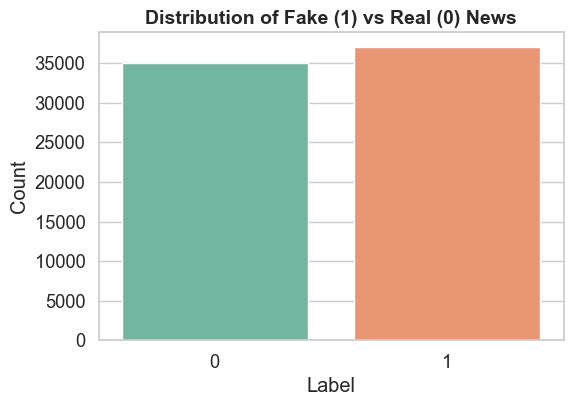

In [9]:
# Label Distribution

plt.figure(figsize=(6,4))
sns.countplot(x=df['label'], palette="Set2", hue = df['label'], legend = False)
plt.title("Distribution of Fake (1) vs Real (0) News", fontsize=14, weight='bold')
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

There is almost **equal** number of both Real and Fake news. So the distribution is almost **Uniform**.

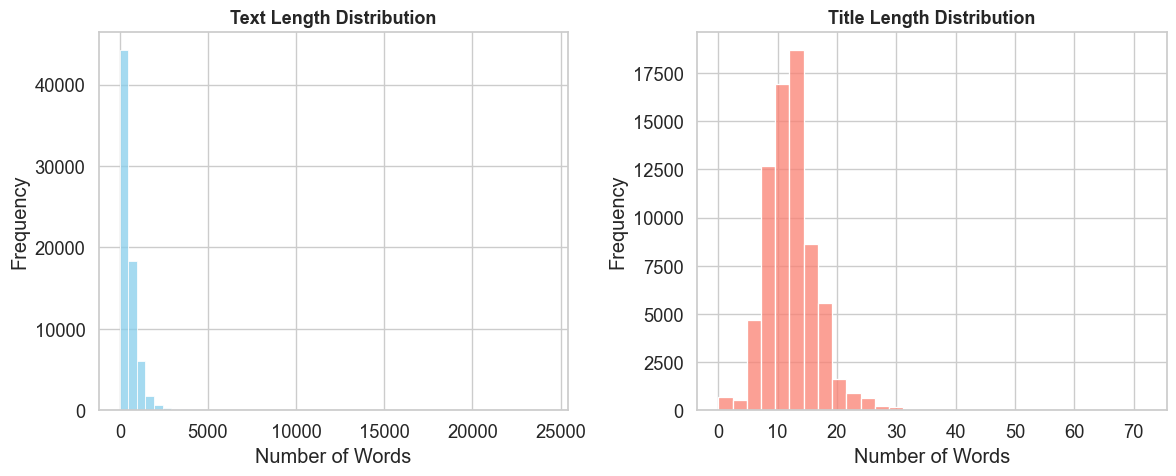

In [10]:
# Text Length Distribution

df['text_len'] = df['text'].apply(lambda x: len(x.split()))
df['title_len'] = df['title'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.histplot(df['text_len'], bins=50, ax=axes[0], color="skyblue")
axes[0].set_title("Text Length Distribution", fontsize=13, weight='bold')
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Frequency")

sns.histplot(df['title_len'], bins=30, ax=axes[1], color="salmon")
axes[1].set_title("Title Length Distribution", fontsize=13, weight='bold')
axes[1].set_xlabel("Number of Words")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

1. The length of title is ranging from **0-30** words. With most of the titles ranging from **10** to **20** words.
2. The length of text description is ranging from **0-2500** words. Most of them lie in the range **0-1000** words.

In [11]:
from wordcloud import WordCloud

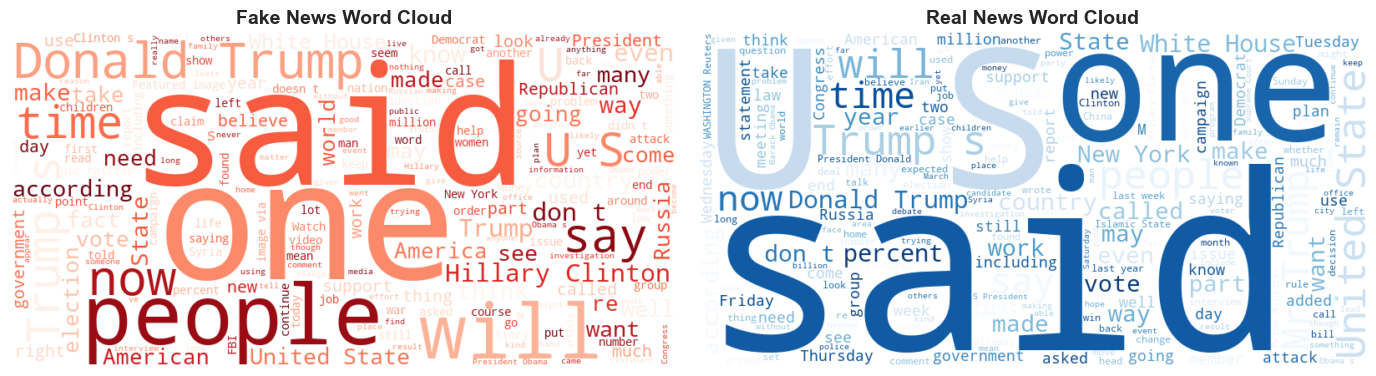

In [12]:
# Word Clouds.

fake_text = " ".join(df[df['label']==1]['text'])
real_text = " ".join(df[df['label']==0]['text'])

wc_fake = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(fake_text)
wc_real = WordCloud(width=800, height=400, background_color="white", colormap="Blues").generate(real_text)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].imshow(wc_fake, interpolation="bilinear")
axes[0].set_title("Fake News Word Cloud", fontsize=14, weight='bold')
axes[0].axis("off")

axes[1].imshow(wc_real, interpolation="bilinear")
axes[1].set_title("Real News Word Cloud", fontsize=14, weight='bold')
axes[1].axis("off")

plt.tight_layout()
plt.show()

1. The most used words in the **Fake News WordCloud** are **said, will, people, one, Trumps** etc.
2. The most used words in the **Real News WordCloud** are **US, said, one, people, White House, government** etc.

# Preprocessing the Data:

In [13]:
# Combine title and text into one column
df['content'] = df['title'] + " " + df['text']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72095 entries, 0 to 72133
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      72095 non-null  object
 1   text       72095 non-null  object
 2   label      72095 non-null  int64 
 3   text_len   72095 non-null  int64 
 4   title_len  72095 non-null  int64 
 5   content    72095 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


# Dropping some unnecessary columns and saving for reference:

In [15]:
# Columns to keep for reference
df_ref = df[['title', 'text', 'text_len', 'title_len']].copy()

# Columns for modeling
df_model = df[['content', 'label']].copy()

# Saving the current preprocessed data to Disk:

In [ ]:
# Save training dataframe
df_model.to_parquet("df_model.parquet", index=False)

# Save reference dataframe
df_ref.to_parquet("df_ref.parquet", index=False)

print("✅ DataFrames saved successfully to disk.")

# Reading the current preprocessed data from Disk:

In [ ]:
# Load training dataframe
df_model = pd.read_parquet("df_model.parquet")

# Load reference dataframe
df_ref = pd.read_parquet("df_ref.parquet")

print("✅ DataFrames loaded successfully from disk.")

In [16]:
print("df_model shape:", df_model.shape)
print("df_ref shape:", df_ref.shape)

df_model shape: (72095, 2)
df_ref shape: (72095, 4)


# Train/Test Split:

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# X = features (content), y = target (label)
X = df_model['content']
y = df_model['label']

In [19]:
# Train-test split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [20]:
print("✅ Data split completed.")
print("Train set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

✅ Data split completed.
Train set size: 57676
Test set size: 14419


# Further Preprocessing:

In [21]:
import re
import spacy
import nltk
from nltk.corpus import stopwords

In [22]:
# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HASHIR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Load spaCy model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [24]:
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove punctuation, digits, and extra spaces
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenize + 4. Remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    
    # 5. Lemmatization with spaCy
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]
    
    return " ".join(tokens)

In [25]:
# Testing
print(preprocess_text("Trump's running quickly in 2020 Elections!!!"))

trump run quickly election


In [26]:
# Apply preprocessing to train and test sets
X_train_clean = X_train.apply(preprocess_text)
X_test_clean = X_test.apply(preprocess_text)

print("✅ Preprocessing complete.")

✅ Preprocessing complete.


# TF-IDF Vectorization:

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [28]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=10000,      
    ngram_range=(1,2),       # unigrams + bigrams
    stop_words='english'    
)

In [29]:
# Fit on training data and transform
X_train_tfidf = tfidf.fit_transform(X_train_clean)

In [30]:
# Transform test data
X_test_tfidf = tfidf.transform(X_test_clean)

In [31]:
print("✅ TF-IDF transformation complete.")
print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)

✅ TF-IDF transformation complete.
Train shape: (57676, 10000)
Test shape: (14419, 10000)


# Saving Raw Preprocesed Text to Parquet Files:

In [32]:
train_processed = pd.DataFrame({
    "content": X_train_clean,
    "label": y_train.reset_index(drop=True)
})

test_processed = pd.DataFrame({
    "content": X_test_clean,
    "label": y_test.reset_index(drop=True)
})

train_processed.to_parquet("train_processed.parquet", index=False)
test_processed.to_parquet("test_processed.parquet", index=False)

print("✅ Preprocessed train/test text saved.")

✅ Preprocessed train/test text saved.


# Saving TF-IDF Vectorized Data to Disk:

In [33]:
import joblib

In [34]:
joblib.dump(X_train_tfidf, "X_train_tfidf.pkl")
joblib.dump(X_test_tfidf, "X_test_tfidf.pkl")
joblib.dump(y_train, "y_train.pkl")
joblib.dump(y_test, "y_test.pkl")

# Save the fitted TF-IDF vectorizer so you can transform new text later
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("✅ TF-IDF features and vectorizer saved.")

✅ TF-IDF features and vectorizer saved.


# Reading Raw Preprocesed Text from Parquet Files:

In [35]:
# Reload preprocessed text
train_processed = pd.read_parquet("train_processed.parquet")
test_processed = pd.read_parquet("test_processed.parquet")

X_train_clean, y_train = train_processed["content"], train_processed["label"]
X_test_clean, y_test = test_processed["content"], test_processed["label"]

# Reading TF-IDF Vectorized Data from Disk:

In [36]:
# Reload TF-IDF features
X_train_tfidf = joblib.load("X_train_tfidf.pkl")
X_test_tfidf = joblib.load("X_test_tfidf.pkl")
y_train = joblib.load("y_train.pkl")
y_test = joblib.load("y_test.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")

print("✅ Data and TF-IDF vectorizer loaded successfully.")

✅ Data and TF-IDF vectorizer loaded successfully.


# Training a Logistic Regression Model:

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

In [38]:
# Range of regularization strengths to test
C_values = [0.01, 0.1, 1, 10, 100]
train_accs = []
cv_accs = []

# Stratified K-Fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [39]:
for C in C_values:
    print(f"\n🔹 Training Logistic Regression with C={C}...")
    
    # Logistic Regression model
    log_reg = LogisticRegression(C=C, max_iter=1000, solver="lbfgs", n_jobs=-1)
    
    # Train accuracy
    log_reg.fit(X_train_tfidf, y_train)
    y_train_pred = log_reg.predict(X_train_tfidf)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_accs.append(train_acc)
    print(f"   ✅ Train Accuracy: {train_acc:.4f}")
    
    # Cross-validation accuracy
    cv_scores = cross_val_score(log_reg, X_train_tfidf, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_acc = np.mean(cv_scores)
    cv_accs.append(cv_acc)
    print(f"   ✅ CV Accuracy (5-fold mean): {cv_acc:.4f}")


🔹 Training Logistic Regression with C=0.01...
   ✅ Train Accuracy: 0.8819
   ✅ CV Accuracy (5-fold mean): 0.8764

🔹 Training Logistic Regression with C=0.1...
   ✅ Train Accuracy: 0.9239
   ✅ CV Accuracy (5-fold mean): 0.9144

🔹 Training Logistic Regression with C=1...
   ✅ Train Accuracy: 0.9587
   ✅ CV Accuracy (5-fold mean): 0.9452

🔹 Training Logistic Regression with C=10...
   ✅ Train Accuracy: 0.9822
   ✅ CV Accuracy (5-fold mean): 0.9562

🔹 Training Logistic Regression with C=100...
   ✅ Train Accuracy: 0.9943
   ✅ CV Accuracy (5-fold mean): 0.9549


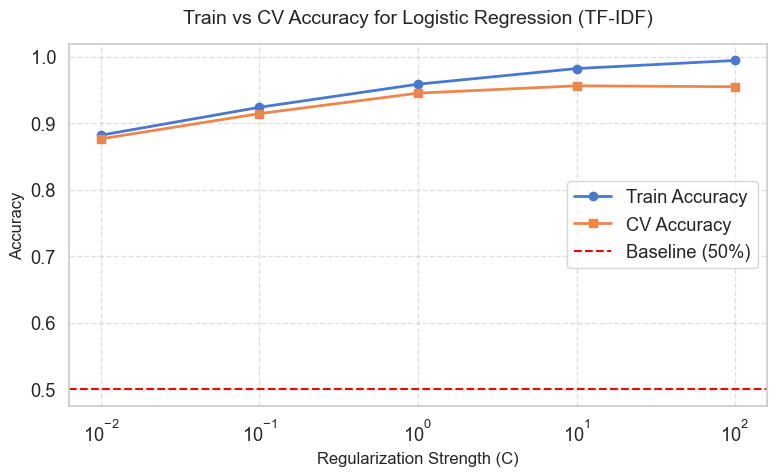

In [40]:
# Baseline (majority class classifier ~ 50%)
baseline_acc = 0.5  

plt.figure(figsize=(8,5))

# Train vs CV accuracy
plt.semilogx(C_values, train_accs, marker='o', label="Train Accuracy", linewidth=2)
plt.semilogx(C_values, cv_accs, marker='s', label="CV Accuracy", linewidth=2)

# Baseline line
plt.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=1.5, label="Baseline (50%)")

# Labels & aesthetics
plt.xlabel("Regularization Strength (C)", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Train vs CV Accuracy for Logistic Regression (TF-IDF)", fontsize=14, pad=15)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Keeping the best Model:

In [41]:
# Final Logistic Regression model with best C
best_C = 1
final_model = LogisticRegression(C=best_C, max_iter=1000, solver="saga", n_jobs=-1)

print(f"\n Training final Logistic Regression model with C={best_C} on full training set...")
final_model.fit(X_train_tfidf, y_train)

print("✅ Model training complete. Ready for test set evaluation.")


 Training final Logistic Regression model with C=1 on full training set...
✅ Model training complete. Ready for test set evaluation.


# Evaluating the Logistic Regression Model:

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [43]:
# Predictions
y_pred = final_model.predict(X_test_tfidf)

# Accuracy
test_acc = accuracy_score(y_test, y_pred)
print(f"✅ Test Accuracy: {test_acc:.4f}")

✅ Test Accuracy: 0.9463


# Evaluation Metrics and Final Results:

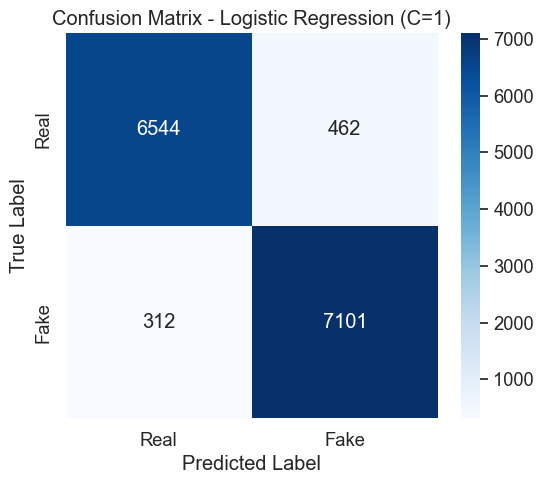

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression (C=1)")
plt.show()

In [45]:
# Precision, Recall, F1 
print("\n📊 Classification Report (Precision, Recall, F1):")
print(classification_report(y_test, y_pred, target_names=["Real", "Fake"]))


📊 Classification Report (Precision, Recall, F1):
              precision    recall  f1-score   support

        Real       0.95      0.93      0.94      7006
        Fake       0.94      0.96      0.95      7413

    accuracy                           0.95     14419
   macro avg       0.95      0.95      0.95     14419
weighted avg       0.95      0.95      0.95     14419



In [46]:
# Ensure both are numpy arrays
y_test_array = y_test.values  

# Misclassification indices
misclassified_idx = np.where(y_test_array != y_pred)[0]

print(f"\n⚠️ Total Misclassifications: {len(misclassified_idx)}")

# Show a few misclassified examples
for i in misclassified_idx[:5]:  # first 5 mistakes
    print("\n--- Misclassified Example ---")
    print(f"True Label: {y_test_array[i]} | Predicted: {y_pred[i]}")
    print(f"Content: {X_test.iloc[i][:300]}...")  # preview first 300 chars


⚠️ Total Misclassifications: 774

--- Misclassified Example ---
True Label: 0 | Predicted: 1
Content: ACLU Launches Nationwide Training on Protest, Resistance Against Trump CORAL GABLES, Fla. (AP)  —   The American Civil Liberties Union staged a nationwide training event Saturday to make sure people are aware of their rights as protesters and urge organized, public resistance by those opposed to pol...

--- Misclassified Example ---
True Label: 1 | Predicted: 0
Content:  Trump Just Literally Gave The WWE A Cabinet Position; World Doomed (DETAILS) Just when you thought things couldn t get crazier and more bizarre in the future Donald Trump administration, the president-elect just nominated ex-WWE CEO Linda McMahon to head the Small Business Administration, which is ...

--- Misclassified Example ---
True Label: 0 | Predicted: 1
Content: Illinois House Passes Automatic Voter Registration Bill The Illinois House passed a bill allowing the state to register eligible voters automatically, 

# Plotting Conclusions:

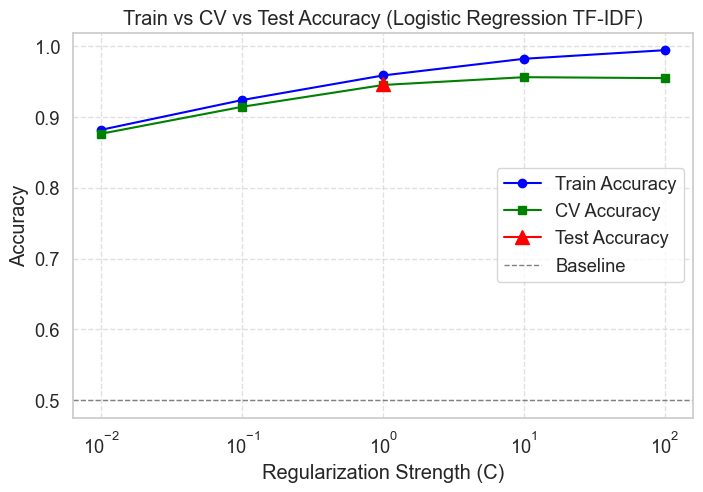

In [49]:
test_accs = [None, None, test_acc, None, None]  # plot only at C=1

# Plot
plt.figure(figsize=(8,5))
plt.semilogx(C_values, train_accs, marker='o', label="Train Accuracy", color="blue")
plt.semilogx(C_values, cv_accs, marker='s', label="CV Accuracy", color="green")
plt.semilogx(C_values, test_accs, marker='^', markersize=10, label="Test Accuracy", color="red")

# Baseline (random guessing ~50%)
plt.axhline(y=0.5, color="gray", linestyle="--", linewidth=1, label="Baseline")

# Labels & Style
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Accuracy")
plt.title("Train vs CV vs Test Accuracy (Logistic Regression TF-IDF)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Saving The Logistic Regression Model:

In [50]:
# Save model
joblib.dump(final_model, "logreg_tfidf_model.pkl")

['logreg_tfidf_model.pkl']

# Loading The Logistic Regression Model:

In [51]:
# Load model 
loaded_model = joblib.load("logreg_tfidf_model.pkl")